# HGQL 2.0.0 Evaluation

In [2]:
import json
import os
import time
import numpy as np
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt
from urllib.parse import quote
import subprocess

from ipywidgets import FloatProgress
from IPython.display import display
from SPARQLWrapper import SPARQLWrapper, JSON
from SPARQLTransformer import sparqlTransformer

In [3]:
INPUT_FOLDER = './queries'

In [4]:
def sparql_exec_dbpedia(query, endpoint):
    url = endpoint + "?query=" + quote(
      query) + "&format=application%2Fsparql-results%2Bjson&CXML_redir_for_subjs=121&CXML_redir_for_hrefs=&timeout=30000&debug=on&run=+Run+Query+"

    payload = {}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload)

    return response.text.encode('utf8')

In [5]:
def sparql_exec(query, endpoint):
    url = endpoint

    payload = "query=" + quote(query)
    headers = {
      'Accept': 'application/sparql-results+json,*/*;q=0.9',
      'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8',
      'X-Requested-With': 'XMLHttpRequest'
    }

    response = requests.request("POST", url, headers=headers, data = payload)

    return response.text.encode('utf8')

In [6]:
def sparql_exec_update(query, endpoint):
    url = endpoint

    payload = 'update=' + quote(query)
    headers = {
      'Accept': 'text/plain,*/*;q=0.9',
      'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8',
      'X-Requested-With': 'XMLHttpRequest'
    }
    response = requests.request("POST", url, headers=headers, data=payload)

    return response.text.encode('utf8')

In [7]:
def sparql_csv_exec(query, endpoint):
    url = endpoint + "?query=" + quote(
      query) + "&format=text/csv&CXML_redir_for_subjs=121&CXML_redir_for_hrefs=&timeout=30000&debug=on&run=+Run+Query+"

    payload = {}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload)

    return response.text.encode('utf8')

In [8]:
def hgql_exec(query, endpoint, debug=False):
    raw_query = (r'{}'.format(query).replace("\n", "").replace('"','\\\"'))
    payload = "{\"query\":\"" + raw_query + "\",\"variables\":{}}"
    headers = {
      'Content-Type': 'application/json'
    }
    response = requests.request("POST", endpoint, headers=headers, data=payload)

    return response.text.encode('utf8')

In [9]:

def json_exec(query, endpoint, debug=False):
    return sparqlTransformer(query, {'endpoint': endpoint, 'debug': debug})

In [10]:
def test_atom(query, endpoint, typ='sparql'):
    start = time.time()
    if typ == 'sparql_dbpedia':
        r = sparql_exec_dbpedia(query, endpoint)
    elif typ == 'sparql':
        r = sparql_exec(query, endpoint)
    elif typ == 'sparql_mutation':
        r = sparql_exec_update(query, endpoint)
    elif typ == 'sparql_csv':
        r = sparql_csv_exec(query, endpoint)
    elif typ == 'json':
        r = json_exec(query, endpoint)
    else:
        r = hgql_exec(query, endpoint)
      

    end = time.time()
    timing = end - start
    return len(str(r)), timing

In [11]:
def wait_for_server(server):
    done = False
    while(not done):
        answer = input("Close current HGQL instannce and start %s. Done? Confirm with y if the server is accessible" % server)
        if answer == 'y':
            done = True

## Evaluation Parameter
- num_iteration: Defines the number of times each query is executed
- sleep_time: idle time between queries (To avoid network influences)

In [12]:
num_iteration = 100
sleep_time = 0.1

In [13]:
def mean_without_outliers(x):
    df = pd.DataFrame(x)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    return float(df[(df >= Q1 - 1.5 * IQR) | (df <= Q3 + 1.5 * IQR)].mean())

### Execute and save
 Method that executes the given query and saves the result.

In [14]:
def save_res_exec_query(title, query, endpoint, typ, folder):
    if typ == 'sparql':
        r = sparql_exec(query, endpoint)
        open('%s/%s_sparql.json' % (folder, title), 'w').write(r.decode())
    elif typ == 'sparql_dbpedia':
        r = sparql_exec_dbpedia(query, endpoint)
        open('%s/%s_sparql.json' % (folder, title), 'w').write(r.decode())
    elif typ == 'sparql_csv':
        r = sparql_csv_exec(query, endpoint)
        open('%s/%s_sparql.csv' % (folder, title), 'w').write(r.decode())
    elif typ == 'json':
        r = json_exec(query, endpoint)
        res = str(r)
        open('%s/%s_transformer.json' % (folder, title), 'w').write(res)
    elif typ == 'hgql_1':
        r = hgql_exec(query, endpoint)
        res = str(r)
        open('%s/%s_hgql_1.json' % (folder, title), 'w').write(res)
    elif typ == 'hgql_2_standalone':
        r = hgql_exec(query, endpoint)
        res = str(r)
        open('%s/%s_hgql_2_standalone.json' % (folder, title), 'w').write(res)
    else:
        r = hgql_exec(query, endpoint)
        open('%s/%s_hgql.json' % (folder, title), 'w').write(r.decode())
    

## Query Tests with One Service

Start HyperGraphQL server - wait 20sec for servert booting

In [14]:
INPUT_FOLDER_ONE_SERVICE = INPUT_FOLDER + '/one_service'
OUTPUT_FOLDER_ONE_SERVICE= INPUT_FOLDER_ONE_SERVICE + '/results'

HGQL_ENDPOINT = 'http://localhost:8098/graphql'
SPARQL_ENDPOINT = 'http://localhost:3030/dataset/query'

hgql1_queries_files = list(filter(lambda x: x.endswith('1.0.3.graphql'), os.listdir(INPUT_FOLDER_ONE_SERVICE)))
hgql1_queries_files.sort()
print(hgql1_queries_files)
hgql2_queries_files = list(filter(lambda x: x.endswith('2.0.0.graphql'), os.listdir(INPUT_FOLDER_ONE_SERVICE)))
hgql2_queries_files.sort()
print(hgql2_queries_files)
rq_queries_files = list(filter(lambda x: x.endswith('.sparql'), os.listdir(INPUT_FOLDER_ONE_SERVICE)))
rq_queries_files.sort()
print(rq_queries_files)
json_queries_files = list(filter(lambda x: x.endswith('.json'), os.listdir(INPUT_FOLDER_ONE_SERVICE)))
json_queries_files.sort()
print(json_queries_files)

hgql1_queries = [open('%s/%s' % (INPUT_FOLDER_ONE_SERVICE, f), 'r').read() for f in hgql1_queries_files]
hgql2_queries = [open('%s/%s' % (INPUT_FOLDER_ONE_SERVICE, f), 'r').read() for f in hgql2_queries_files]
rq_queries = [open('%s/%s' % (INPUT_FOLDER_ONE_SERVICE, f), 'r').read() for f in rq_queries_files]
json_queries = [json.load(open('%s/%s' % (INPUT_FOLDER_ONE_SERVICE, f), 'r')) for f in json_queries_files]

['query_1_hgql_1.0.3.graphql', 'query_2 _hgql_1.0.3.graphql', 'query_3 _hgql_1.0.3.graphql', 'query_4_hgql_1.0.3.graphql']
['query_1_hgql_2.0.0.graphql', 'query_2_hgql_2.0.0.graphql', 'query_3_hgql_2.0.0.graphql', 'query_4_hgql_2.0.0.graphql']
['query_1.sparql', 'query_2.sparql', 'query_3.sparql', 'query_4.sparql']
['query_1.json', 'query_2.json', 'query_3.json', 'query_4.json']


In [15]:
test_results = []
all_timings = []
sizes = []

for i, hgql2_query in enumerate(hgql2_queries):
    # queries
    hgql1_query = hgql1_queries[i]
    hgql2_query = hgql2_queries[i]
    rq_query = rq_queries[i]
    json_query = json_queries[i]
    title = rq_queries_files[i].replace('.sparql', '')
    print(title)

    # progress bars
    fs = FloatProgress(min=0, max=num_iteration, description='SPARQL JSON test:')
    display(fs)
    fc = FloatProgress(min=0, max=num_iteration, description='SPARQL CSV test:')
    display(fc)
    ft = FloatProgress(min=0, max=num_iteration, description='SPARQL Transformer test:')
    display(ft)
    fh1 = FloatProgress(min=0, max=num_iteration, description='HGQL 1.0.3 test:')
    display(fh1)
    fh2 = FloatProgress(min=0, max=num_iteration, description='HGQL 2.0.0 test:')
    display(fh2)
    fh2s = FloatProgress(min=0, max=num_iteration, description='HGQL 2.0.0 Standalone test:')
    display(fh2s)

    sparql_time = []
    sparql_results = 0
    sparql_csv_time = []
    sparql_csv_results = 0
    hgql1_time = []
    hgql1_results = 0
    hgql2_time = []
    hgql2_results = 0
    hgql2s_time = []
    hgql2s_results = 0
    json_time = []
    json_results = 0
    print("SPARQL JSON")
    save_res_exec_query(title, rq_query, SPARQL_ENDPOINT, folder=OUTPUT_FOLDER_ONE_SERVICE, typ='sparql')
    for j in np.arange(num_iteration):
        if (i + j) > 0:
                time.sleep(sleep_time)
        size, t = test_atom(rq_query, SPARQL_ENDPOINT, typ='sparql')
        sparql_time.append(t)
        sparql_results = size
        fs.value += 1
    print("SPARQL CSV")
    save_res_exec_query(title, rq_query, SPARQL_ENDPOINT, folder=OUTPUT_FOLDER_ONE_SERVICE, typ='sparql_csv')
    for j in np.arange(num_iteration):
        if (i + j) > 0:
                time.sleep(sleep_time)
        size, t = test_atom(rq_query, SPARQL_ENDPOINT, typ='sparql_csv')
        sparql_csv_time.append(t)
        sparql_csv_results = size
        fc.value += 1
    print("HGQL 2.0.0")
    wait_for_server("HGQL 2.0.0")
    save_res_exec_query(title, hgql2_query, HGQL_ENDPOINT, folder=OUTPUT_FOLDER_ONE_SERVICE, typ='hgql')
    for j in np.arange(num_iteration):
        time.sleep(sleep_time)
        size, t = test_atom(hgql2_query, HGQL_ENDPOINT, typ='hgql')
        hgql2_time.append(t)
        hgql2_results = size
        fh2.value += 1

    
    print("HGQL 1.0.3")
    wait_for_server("HGQL 1.0.3")
    save_res_exec_query(title, hgql1_query, HGQL_ENDPOINT, folder=OUTPUT_FOLDER_ONE_SERVICE, typ='hgql_1')
    for j in np.arange(num_iteration):
        time.sleep(sleep_time)
        size, t = test_atom(hgql1_query,HGQL_ENDPOINT, typ='hgql')
        hgql1_time.append(t)
        hgql1_results = size
        fh1.value += 1

    
    print("HGQL 2.0.0 Standalone")
    wait_for_server("HGQL 2.0.0 Standalone")
    save_res_exec_query(title, hgql2_query, HGQL_ENDPOINT, folder=OUTPUT_FOLDER_ONE_SERVICE, typ='hgql_2_standalone')
    for j in np.arange(num_iteration):
        time.sleep(sleep_time)
        size, t = test_atom(hgql2_query,HGQL_ENDPOINT, typ='hgql')
        hgql2s_time.append(t)
        hgql2s_results = size
        fh2s.value += 1   

    print("SPARQLTransformer")
    save_res_exec_query(title, json_query, SPARQL_ENDPOINT, folder=OUTPUT_FOLDER_ONE_SERVICE, typ='json')
    for j in np.arange(num_iteration):
        time.sleep(sleep_time)
        size, t = test_atom(json_query,SPARQL_ENDPOINT, typ='json')
        json_time.append(t)
        json_results = size
        ft.value += 1

    ts = np.mean(sparql_time)
    tc = np.mean(sparql_csv_time)
    th1 = np.mean(hgql1_time)
    th2 = np.mean(hgql2_time)
    th2s = np.mean(hgql2s_time)
    tj = np.mean(json_time)
    time_diff_to_sparql = (th2 - ts)
    time_diff_to_sparql_transformer = (th2 - tj)
    time_diff_to_sparql_csv = (th2 - tc)
    time_diff_to_hgql1 = (th2 - th1)
    time_diff_to_hgql2s = (th2-th2s)
    time_diff_percent_to_sparql = 100 * (ts / th2)
    time_diff_percent_to_sparql_transformer = 100 * (tj / th2)
    time_diff_percent_to_sparql_csv = 100 * (tc / th2)
    time_diff_percent_to_hgql1 = 100 * (th1 / th2)
    time_diff_percent_to_sparq2s = 100 * (th2s / th2)

    test_results.append({
      'name': title,
      'time_sparql': ts,
      'result_sparql': sparql_results,
      'time_json': tj,
      'result_json': json_results,
      'time_hgql_1': th1,
      'result_hgql_1': hgql1_results,
      'time_hgql_2_standalone': th2s,
      'result_hgql_2_standalone': hgql2s_results,
      'time_hgql_2': th2,
      'result_hgql_2': hgql2_results,
      'time_diff_to_sparql': '{0:.2g}'.format(time_diff_to_sparql),
      'time_diff_percent_to_sparql': '{0:.2g}%'.format(time_diff_percent_to_sparql),
      'time_diff_to_sparql_transformer': '{0:.2g}'.format(time_diff_to_sparql_transformer),
      'time_diff_percent_to_sparql_transformer': '{0:.2g}%'.format(time_diff_percent_to_sparql_transformer),
      'time_diff_to_sparql_csv': '{0:.2g}%'.format(time_diff_to_sparql_csv),
      'time_diff_to_hgql_1': '{0:.2g}%'.format(time_diff_to_hgql1),
      'time_diff_to_hgql_standalone': '{0:.2g}%'.format(time_diff_to_hgql2s),
    });

    all_timings.append({
      'name': title,
      'hgql1': hgql1_time,
      'hgql2': hgql2_time,
      'hgql2s': hgql2s_time,
      'sparql': sparql_time,
      'sparql_csv':sparql_csv_time,
      'json': json_time
    })
    
    sizes.append({
      'name': title,
      'hgql1': hgql1_results,
      'hgql2': hgql2_results,
      'hgql2s': hgql2s_results,
      'sparql_csv': sparql_csv_results,
      'json': json_results,
      'sparql': sparql_results
    })
    print(sizes)

query_1


FloatProgress(value=0.0, description='SPARQL JSON test:')

FloatProgress(value=0.0, description='SPARQL CSV test:')

FloatProgress(value=0.0, description='SPARQL Transformer test:')

FloatProgress(value=0.0, description='HGQL 1.0.3 test:')

FloatProgress(value=0.0, description='HGQL 2.0.0 test:')

FloatProgress(value=0.0, description='HGQL 2.0.0 Standalone test:')

SPARQL JSON
SPARQL CSV
HGQL 2.0.0


Close current HGQL instannce and start HGQL 2.0.0. Done? Confirm with y if the server is accessible y


HGQL 1.0.3


Close current HGQL instannce and start HGQL 1.0.3. Done? Confirm with y if the server is accessible y


HGQL 2.0.0 Standalone


Close current HGQL instannce and start HGQL 2.0.0 Standalone. Done? Confirm with y if the server is accessible y


SPARQLTransformer
[{'name': 'query_1', 'hgql1': 30081, 'hgql2': 30069, 'hgql2s': 30069, 'sparql_csv': 18243, 'json': 37333, 'sparql': 73991}]
query_2


FloatProgress(value=0.0, description='SPARQL JSON test:')

FloatProgress(value=0.0, description='SPARQL CSV test:')

FloatProgress(value=0.0, description='SPARQL Transformer test:')

FloatProgress(value=0.0, description='HGQL 1.0.3 test:')

FloatProgress(value=0.0, description='HGQL 2.0.0 test:')

FloatProgress(value=0.0, description='HGQL 2.0.0 Standalone test:')

SPARQL JSON
SPARQL CSV
HGQL 2.0.0


Close current HGQL instannce and start HGQL 2.0.0. Done? Confirm with y if the server is accessible y


HGQL 1.0.3


Close current HGQL instannce and start HGQL 1.0.3. Done? Confirm with y if the server is accessible y


HGQL 2.0.0 Standalone


Close current HGQL instannce and start HGQL 2.0.0 Standalone. Done? Confirm with y if the server is accessible y


SPARQLTransformer
[{'name': 'query_1', 'hgql1': 30081, 'hgql2': 30069, 'hgql2s': 30069, 'sparql_csv': 18243, 'json': 37333, 'sparql': 73991}, {'name': 'query_2', 'hgql1': 10426, 'hgql2': 10414, 'hgql2s': 10414, 'sparql_csv': 5082, 'json': 10052, 'sparql': 33981}]
query_3


FloatProgress(value=0.0, description='SPARQL JSON test:')

FloatProgress(value=0.0, description='SPARQL CSV test:')

FloatProgress(value=0.0, description='SPARQL Transformer test:')

FloatProgress(value=0.0, description='HGQL 1.0.3 test:')

FloatProgress(value=0.0, description='HGQL 2.0.0 test:')

FloatProgress(value=0.0, description='HGQL 2.0.0 Standalone test:')

SPARQL JSON
SPARQL CSV
HGQL 2.0.0


Close current HGQL instannce and start HGQL 2.0.0. Done? Confirm with y if the server is accessible y


HGQL 1.0.3


Close current HGQL instannce and start HGQL 1.0.3. Done? Confirm with y if the server is accessible y


HGQL 2.0.0 Standalone


Close current HGQL instannce and start HGQL 2.0.0 Standalone. Done? Confirm with y if the server is accessible y


SPARQLTransformer
[{'name': 'query_1', 'hgql1': 30081, 'hgql2': 30069, 'hgql2s': 30069, 'sparql_csv': 18243, 'json': 37333, 'sparql': 73991}, {'name': 'query_2', 'hgql1': 10426, 'hgql2': 10414, 'hgql2s': 10414, 'sparql_csv': 5082, 'json': 10052, 'sparql': 33981}, {'name': 'query_3', 'hgql1': 5746, 'hgql2': 5716, 'hgql2s': 5716, 'sparql_csv': 8244, 'json': 7363, 'sparql': 23024}]
query_4


FloatProgress(value=0.0, description='SPARQL JSON test:')

FloatProgress(value=0.0, description='SPARQL CSV test:')

FloatProgress(value=0.0, description='SPARQL Transformer test:')

FloatProgress(value=0.0, description='HGQL 1.0.3 test:')

FloatProgress(value=0.0, description='HGQL 2.0.0 test:')

FloatProgress(value=0.0, description='HGQL 2.0.0 Standalone test:')

SPARQL JSON
SPARQL CSV
HGQL 2.0.0


Close current HGQL instannce and start HGQL 2.0.0. Done? Confirm with y if the server is accessible y


HGQL 1.0.3


Close current HGQL instannce and start HGQL 1.0.3. Done? Confirm with y if the server is accessible y


HGQL 2.0.0 Standalone


Close current HGQL instannce and start HGQL 2.0.0 Standalone. Done? Confirm with y if the server is accessible y


SPARQLTransformer
[{'name': 'query_1', 'hgql1': 30081, 'hgql2': 30069, 'hgql2s': 30069, 'sparql_csv': 18243, 'json': 37333, 'sparql': 73991}, {'name': 'query_2', 'hgql1': 10426, 'hgql2': 10414, 'hgql2s': 10414, 'sparql_csv': 5082, 'json': 10052, 'sparql': 33981}, {'name': 'query_3', 'hgql1': 5746, 'hgql2': 5716, 'hgql2s': 5716, 'sparql_csv': 8244, 'json': 7363, 'sparql': 23024}, {'name': 'query_4', 'hgql1': 2500739, 'hgql2': 2500727, 'hgql2s': 2500727, 'sparql_csv': 4792393, 'json': 2405974, 'sparql': 13199637}]


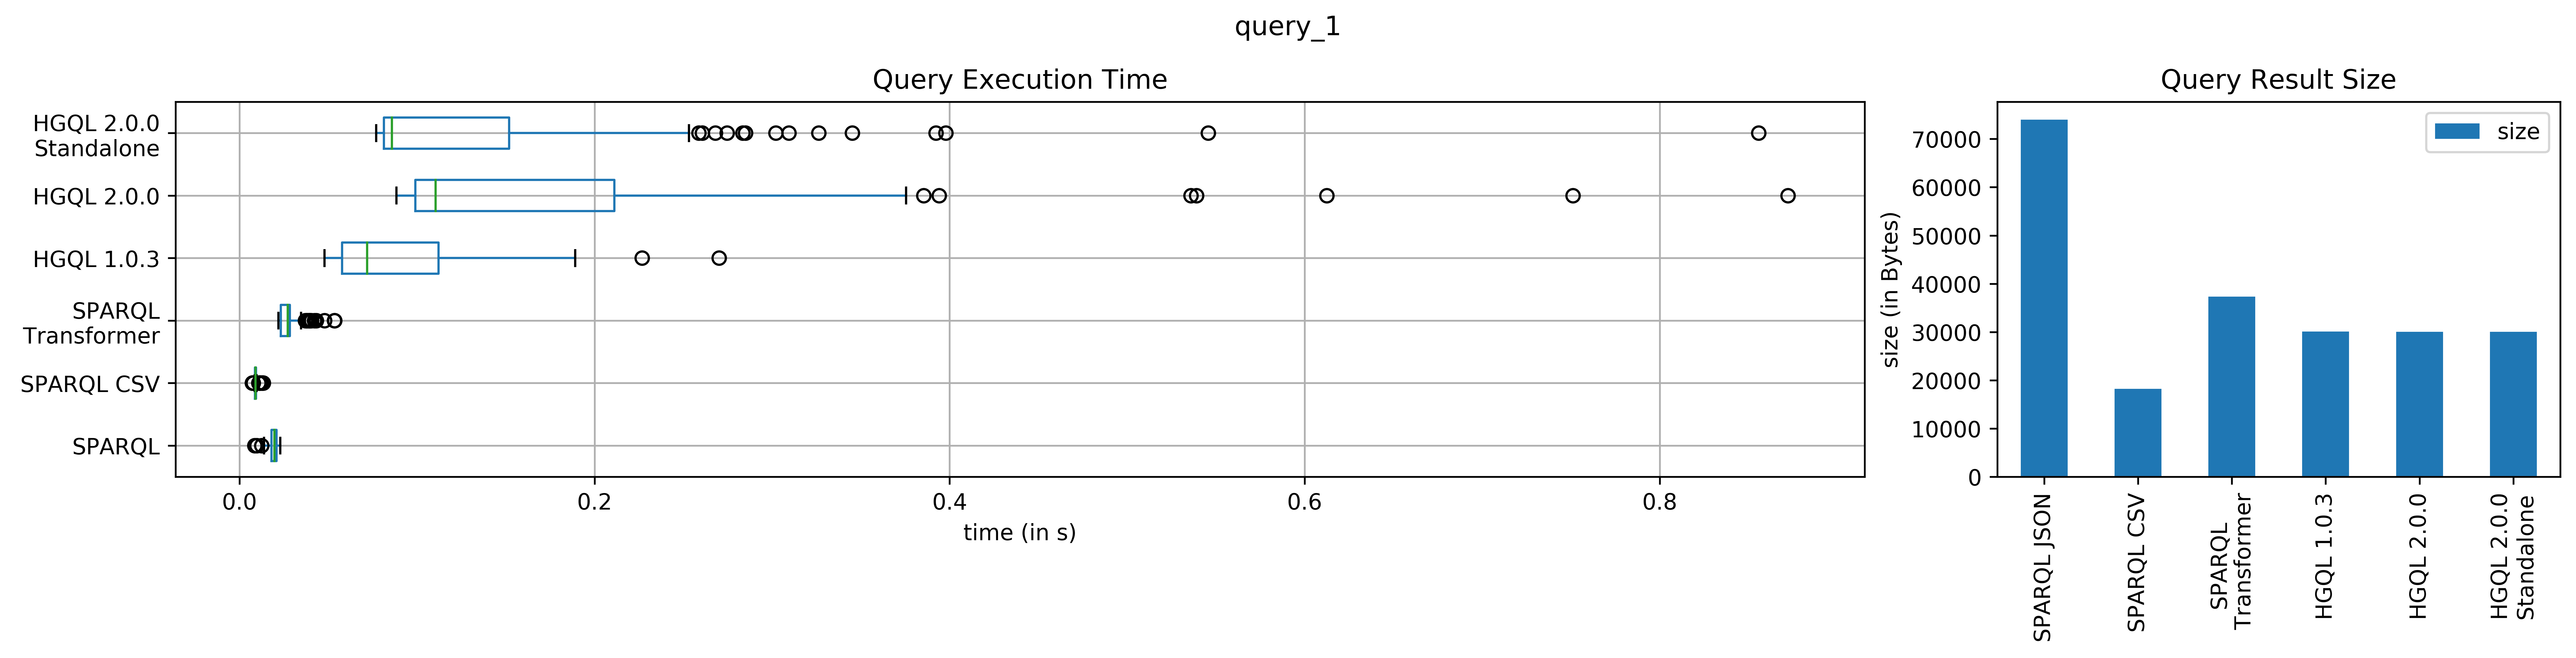

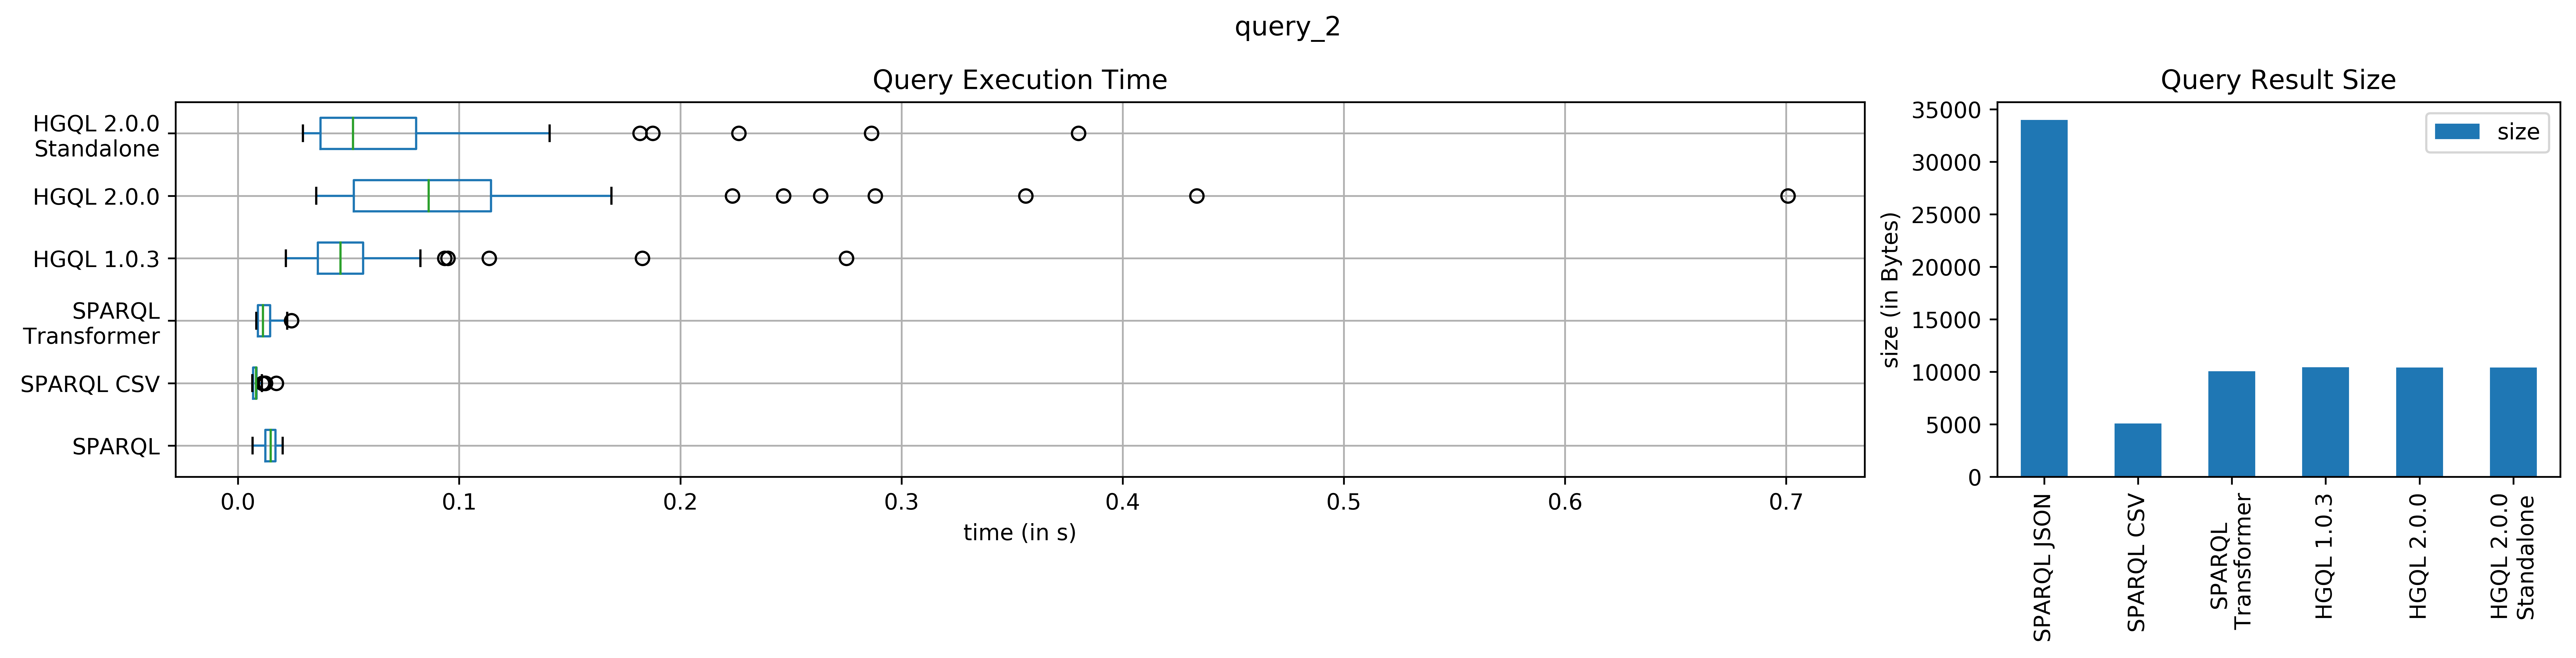

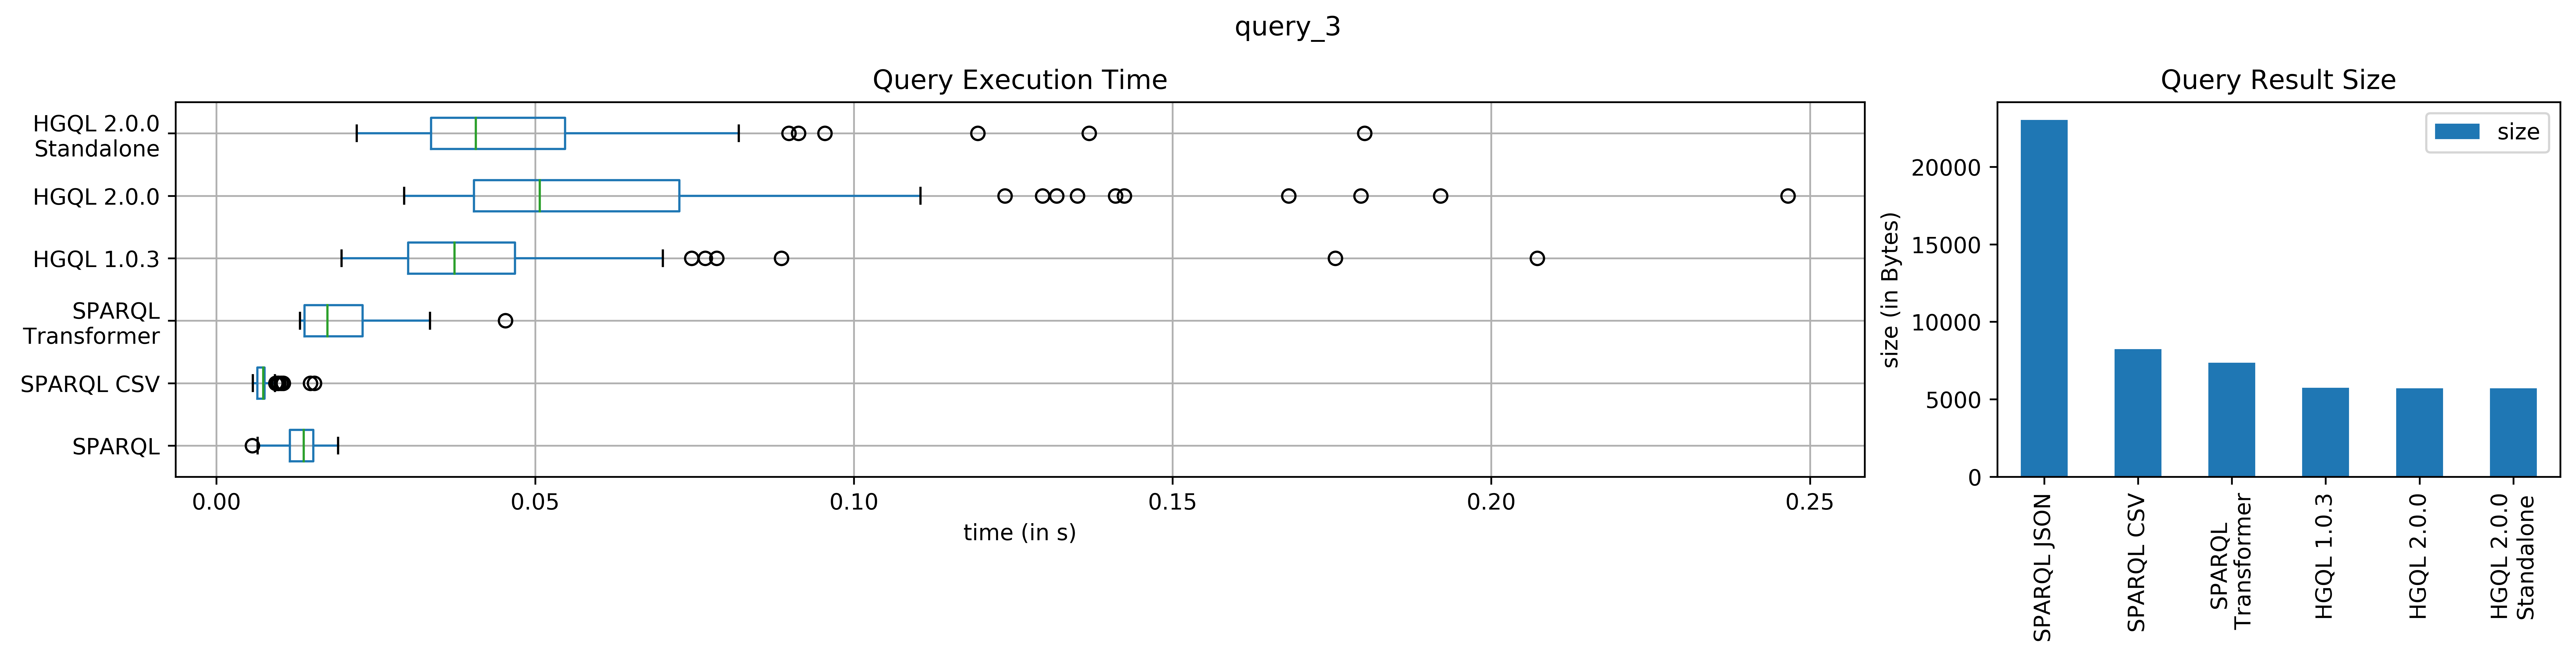

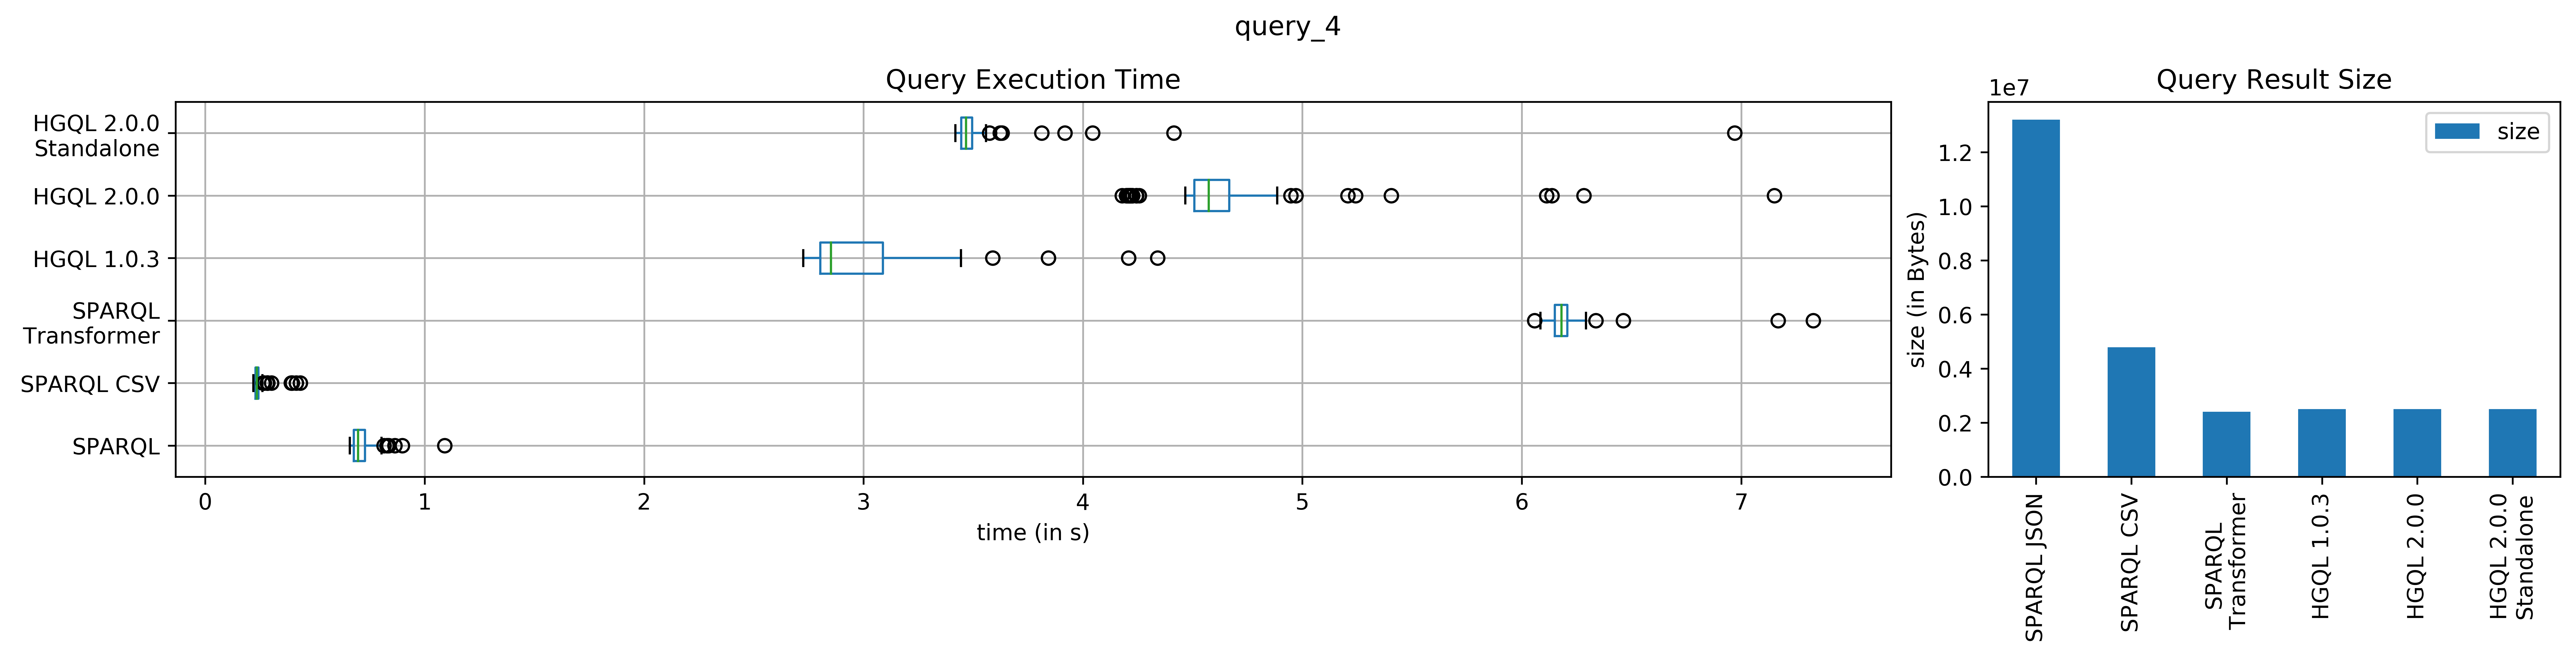

In [16]:
for i, hgql_query in enumerate(hgql2_queries):   
    tim = all_timings[i]
    size = sizes[i]
    label = ['SPARQL JSON', 'SPARQL CSV', 'SPARQL\n Transformer', 'HGQL 1.0.3','HGQL 2.0.0','HGQL 2.0.0\nStandalone']
    y_pos = np.arange(len(label))
    df2 = pd.DataFrame({"method":label,'size': [size['sparql'],size['sparql_csv'],size['json'],size['hgql1'],size['hgql2'],size['hgql2s']]})
    a = np.array([np.hstack(tim['sparql']),np.hstack(tim['sparql_csv']),np.hstack(tim['json']), np.hstack(tim['hgql1']), np.hstack(tim['hgql2']), np.hstack(tim['hgql2s'])]).transpose()
    df = pd.DataFrame(a, columns=['SPARQL','SPARQL CSV', 'SPARQL\n Transformer', 'HGQL 1.0.3', 'HGQL 2.0.0', 'HGQL 2.0.0\nStandalone'])
    
    fig3 = plt.figure(constrained_layout=True,figsize=(16, 4),dpi=600)   
    gs = fig3.add_gridspec(1, 20)
    f3_ax1 = fig3.add_subplot(gs[0, :15])
    df.boxplot(ax=f3_ax1,vert=False, figsize=(16, 4))
    f3_ax1.set_title('Query Execution Time')
    f3_ax1.set_xlabel('time (in s)')
    f3_ax2 = fig3.add_subplot(gs[0, 15:])
    df2[['method','size']].plot(ax=f3_ax2, kind='bar')
    f3_ax2.set_title('Query Result Size')
    f3_ax2.set_xticklabels(label, minor=False)
    f3_ax2.set_ylabel('size (in Bytes)')
    fig3.suptitle(tim['name'])
    fig3.savefig("%s/%s.pdf" % (OUTPUT_FOLDER_ONE_SERVICE, tim['name']), bbox_inches='tight')


In [17]:
pd.DataFrame.from_dict(test_results)

name  time_sparql  result_sparql  time_json  result_json  time_hgql_1  \
0  query_1     0.019063          73991   0.027996        37333     0.088459   
1  query_2     0.014487          33981   0.012095        10052     0.050861   
2  query_3     0.013188          23024   0.018969         7363     0.042677   
3  query_4     0.715272       13199637   6.204411      2405974     2.972956   

   result_hgql_1  time_hgql_2_standalone  result_hgql_2_standalone  \
0          30081                0.138668                     30069   
1          10426                0.068102                     10414   
2           5746                0.048273                      5716   
3        2500739                3.529890                   2500727   

   time_hgql_2  result_hgql_2 time_diff_to_sparql time_diff_percent_to_sparql  \
0     0.180299          30069                0.16                         11%   
1     0.102711          10414               0.088                         14%   
2     0.064252           5716               0.051                         21%   
3     4.644646        2500727                 3.9                         15%   

  time_diff_to_sparql_transformer time_diff_percent_to_sparql_transformer  \
0                            0.15                                     16%   
1                           0.091                                     12%   
2                           0.045                                     30%   
3                            -1.6                                1.3e+02%   

  time_diff_to_sparql_csv time_diff_to_hgql_1 time_diff_to_hgql_standalone  
0                   0.17%              0.092%                       0.042%  
1                  0.095%              0.052%                       0.035%  
2                  0.057%              0.022%                       0.016%  
3                    4.4%                1.7%                         1.1%

## Query Test with Multiple Services

In [18]:
INPUT_FOLDER_MULTIPLE_SERVICES = INPUT_FOLDER + '/multiple_services'
OUTPUT_FOLDER_MULTIPLE_SERVICES= INPUT_FOLDER_MULTIPLE_SERVICES + '/results'

HGQL_ENDPOINT = 'http://localhost:8098/graphql'
SPARQL_ENDPOINT = 'http://localhost:3030/ex_person/query'

hgql2_queries_files = list(filter(lambda x: x.endswith('.graphql'), os.listdir(INPUT_FOLDER_MULTIPLE_SERVICES)))
hgql2_queries_files.sort()
print(hgql2_queries_files)
rq_queries_files = list(filter(lambda x: x.endswith('.sparql'), os.listdir(INPUT_FOLDER_MULTIPLE_SERVICES)))
rq_queries_files.sort()
print(rq_queries_files)

hgql2_queries = [open('%s/%s' % (INPUT_FOLDER_MULTIPLE_SERVICES, f), 'r').read() for f in hgql2_queries_files]
rq_queries = [open('%s/%s' % (INPUT_FOLDER_MULTIPLE_SERVICES, f), 'r').read() for f in rq_queries_files]

['query_1.graphql', 'query_2.graphql', 'query_3.graphql']
['query_1.sparql', 'query_2.sparql', 'query_3.sparql']


In [19]:
test_results = []
all_timings = []
sizes = []

for i, hgql2_query in enumerate(hgql2_queries):
    # queries
    hgql2_query = hgql2_queries[i]
    rq_query = rq_queries[i]
    title = rq_queries_files[i].replace('.sparql', '')
    print(title)

    # progress bars
    fs = FloatProgress(min=0, max=num_iteration, description='SPARQL JSON test:')
    display(fs)
    fc = FloatProgress(min=0, max=num_iteration, description='SPARQL CSV test:')
    display(fc)
    fh2 = FloatProgress(min=0, max=num_iteration, description='HGQL 2.0.0 test:')
    display(fh2)
    fh2s = FloatProgress(min=0, max=num_iteration, description='HGQL 2.0.0 Standalone test:')
    display(fh2s)

    sparql_time = []
    sparql_results = 0
    sparql_csv_time = []
    sparql_csv_results = 0
    hgql2_time = []
    hgql2_results = 0
    hgql2s_time = []
    hgql2s_results = 0
    print("SPARQL JSON")
    save_res_exec_query(title, rq_query, SPARQL_ENDPOINT, folder=OUTPUT_FOLDER_MULTIPLE_SERVICES, typ='sparql')
    for j in np.arange(num_iteration):
        if (i + j) > 0:
                time.sleep(sleep_time)
        size, t = test_atom(rq_query, SPARQL_ENDPOINT, typ='sparql')
        sparql_time.append(t)
        sparql_results = size
        fs.value += 1
    print("SPARQL CSV")
    save_res_exec_query(title, rq_query, SPARQL_ENDPOINT, folder=OUTPUT_FOLDER_MULTIPLE_SERVICES, typ='sparql_csv')
    for j in np.arange(num_iteration):
        if (i + j) > 0:
                time.sleep(sleep_time)
        size, t = test_atom(rq_query, SPARQL_ENDPOINT, typ='sparql_csv')
        sparql_csv_time.append(t)
        sparql_csv_results = size
        fc.value += 1
    print("HGQL 2.0.0")
    wait_for_server("HGQL 2.0.0")
    save_res_exec_query(title, hgql2_query, HGQL_ENDPOINT, folder=OUTPUT_FOLDER_MULTIPLE_SERVICES, typ='hgql')
    for j in np.arange(num_iteration):
        time.sleep(sleep_time)
        size, t = test_atom(hgql2_query, HGQL_ENDPOINT, typ='hgql')
        hgql2_time.append(t)
        hgql2_results = size
        fh2.value += 1
    
    print("HGQL 2.0.0 Standalone")
    wait_for_server("HGQL 2.0.0 Standalone")
    save_res_exec_query(title, hgql2_query, HGQL_ENDPOINT, folder=OUTPUT_FOLDER_MULTIPLE_SERVICES, typ='hgql_2_standalone')
    for j in np.arange(num_iteration):
        time.sleep(sleep_time)
        size, t = test_atom(hgql2_query,HGQL_ENDPOINT, typ='hgql')
        hgql2s_time.append(t)
        hgql2s_results = size
        fh2s.value += 1   

    ts = np.mean(sparql_time)
    tc = np.mean(sparql_csv_time)
    th2 = np.mean(hgql2_time)
    th2s = np.mean(hgql2s_time)
    time_diff_to_sparql = (th2 - ts)
    time_diff_to_sparql_csv = (th2 - tc)
    time_diff_to_hgql2s = (th2-th2s)
    time_diff_percent_to_sparql = 100 * (ts / th2)
    time_diff_percent_to_sparql_csv = 100 * (tc / th2)
    time_diff_percent_to_sparq2s = 100 * (th2s / th2)

    test_results.append({
      'name': title,
      'time_sparql': ts,
      'result_sparql': sparql_results,
      'time_hgql_2_standalone': th2s,
      'result_hgql_2_standalone': hgql2s_results,
      'time_hgql_2': th2,
      'result_hgql_2': hgql2_results,
      'time_diff_to_sparql': '{0:.2g}'.format(time_diff_to_sparql),
      'time_diff_percent_to_sparql': '{0:.2g}%'.format(time_diff_percent_to_sparql),
      'time_diff_percent_to_sparql_transformer': '{0:.2g}%'.format(time_diff_percent_to_sparql_transformer),
      'time_diff_to_sparql_csv': '{0:.2g}%'.format(time_diff_to_sparql_csv),
      'time_diff_to_hgql_standalone': '{0:.2g}%'.format(time_diff_to_hgql2s),
    });

    all_timings.append({
      'name': title,
      'hgql2': hgql2_time,
      'hgql2s': hgql2s_time,
      'sparql': sparql_time,
      'sparql_csv':sparql_csv_time,
    })
    
    sizes.append({
      'name': title,
      'hgql2': hgql2_results,
      'hgql2s': hgql2s_results,
      'sparql_csv': sparql_csv_results,
      'sparql': sparql_results
    })

query_1


FloatProgress(value=0.0, description='SPARQL JSON test:')

FloatProgress(value=0.0, description='SPARQL CSV test:')

FloatProgress(value=0.0, description='HGQL 2.0.0 test:')

FloatProgress(value=0.0, description='HGQL 2.0.0 Standalone test:')

SPARQL JSON
SPARQL CSV
HGQL 2.0.0


Close current HGQL instannce and start HGQL 2.0.0. Done? Confirm with y if the server is accessible y


HGQL 2.0.0 Standalone


Close current HGQL instannce and start HGQL 2.0.0 Standalone. Done? Confirm with y if the server is accessible y


query_2


FloatProgress(value=0.0, description='SPARQL JSON test:')

FloatProgress(value=0.0, description='SPARQL CSV test:')

FloatProgress(value=0.0, description='HGQL 2.0.0 test:')

FloatProgress(value=0.0, description='HGQL 2.0.0 Standalone test:')

SPARQL JSON
SPARQL CSV
HGQL 2.0.0


Close current HGQL instannce and start HGQL 2.0.0. Done? Confirm with y if the server is accessible y


HGQL 2.0.0 Standalone


Close current HGQL instannce and start HGQL 2.0.0 Standalone. Done? Confirm with y if the server is accessible y


query_3


FloatProgress(value=0.0, description='SPARQL JSON test:')

FloatProgress(value=0.0, description='SPARQL CSV test:')

FloatProgress(value=0.0, description='HGQL 2.0.0 test:')

FloatProgress(value=0.0, description='HGQL 2.0.0 Standalone test:')

SPARQL JSON
SPARQL CSV
HGQL 2.0.0


Close current HGQL instannce and start HGQL 2.0.0. Done? Confirm with y if the server is accessible y


HGQL 2.0.0 Standalone


Close current HGQL instannce and start HGQL 2.0.0 Standalone. Done? Confirm with y if the server is accessible y


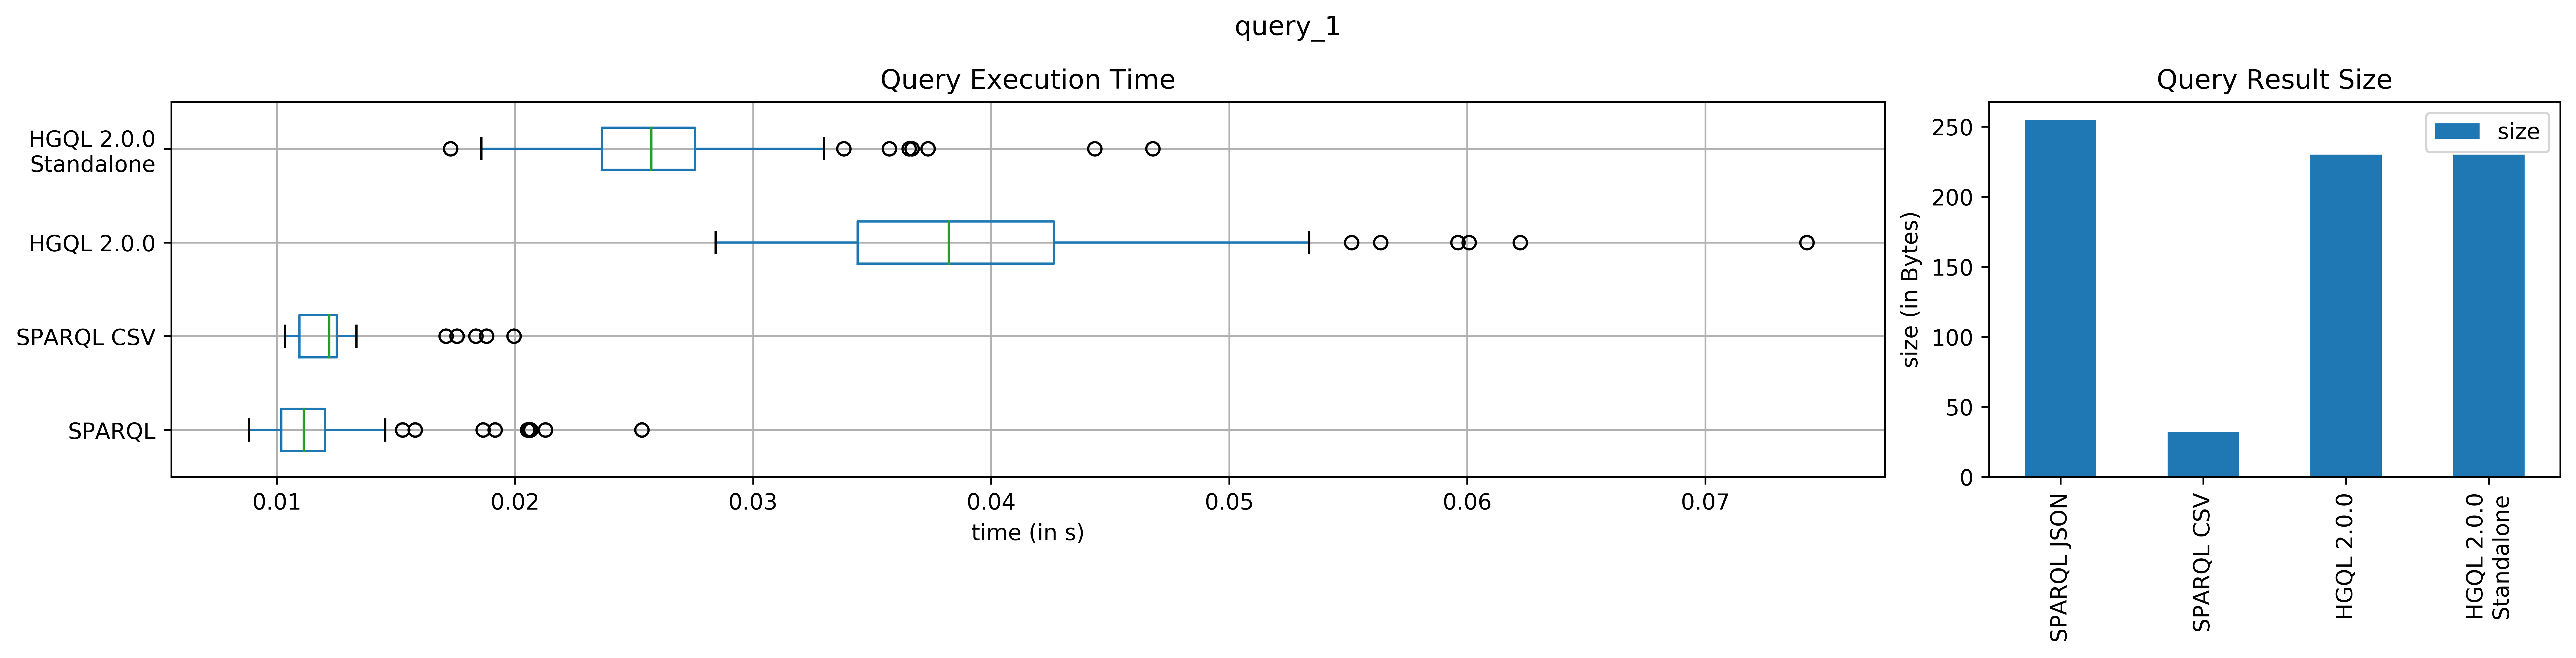

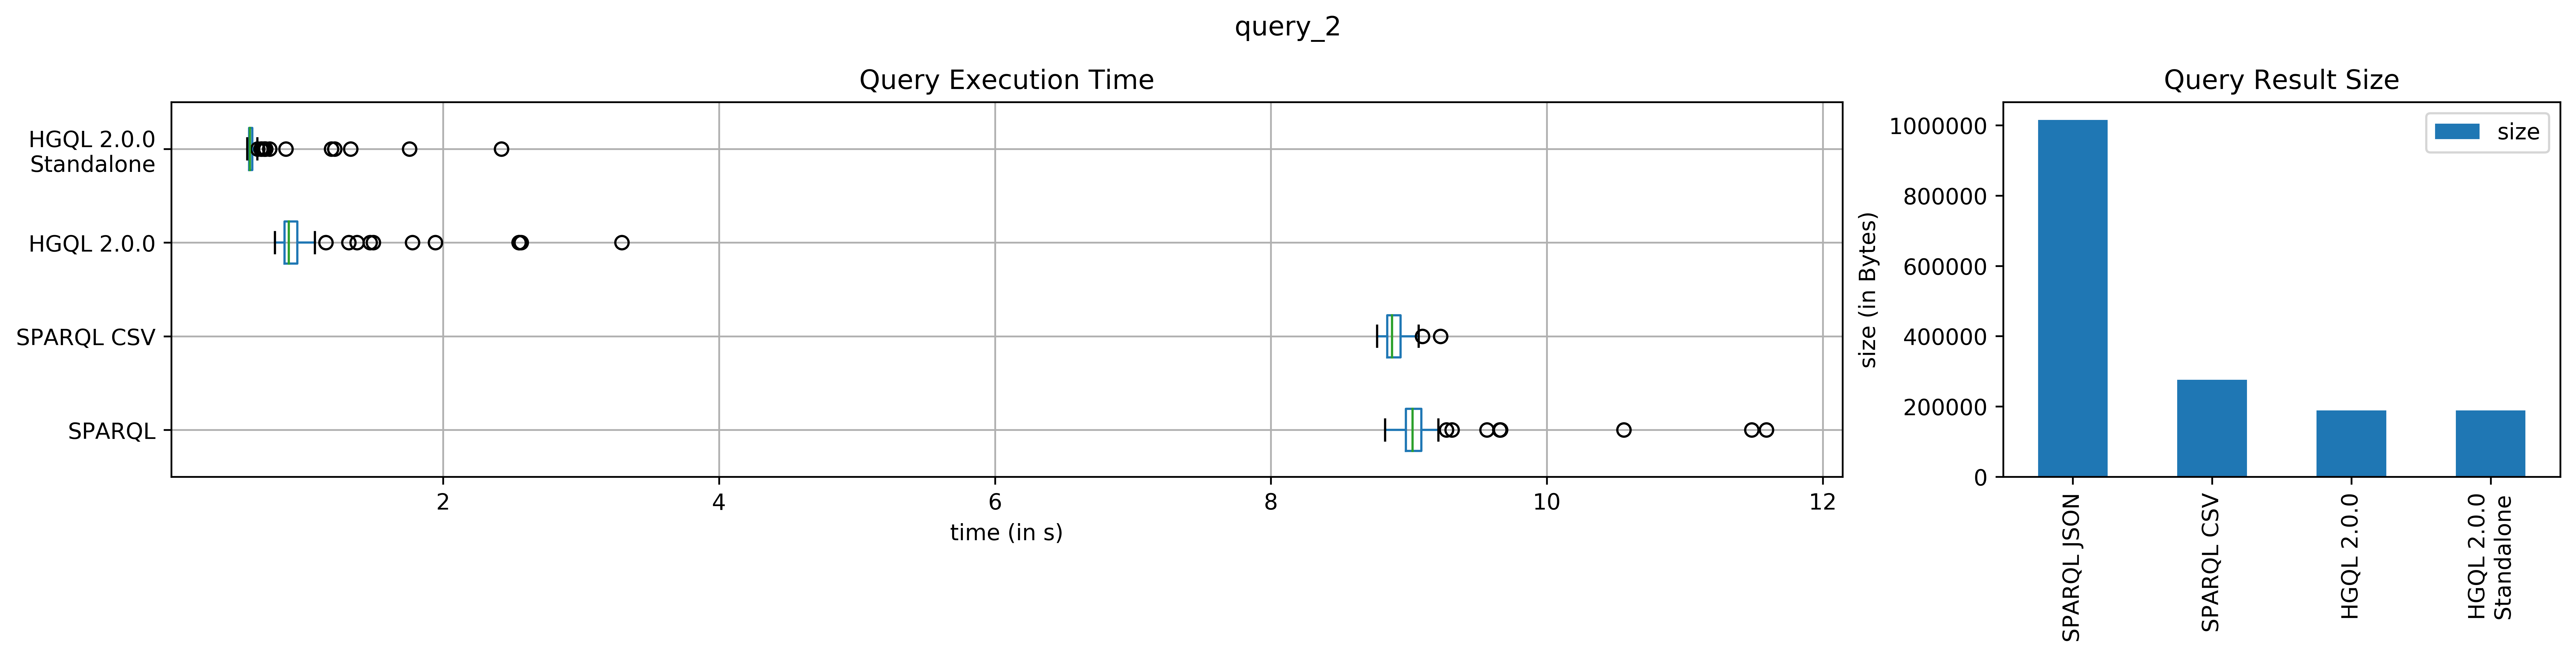

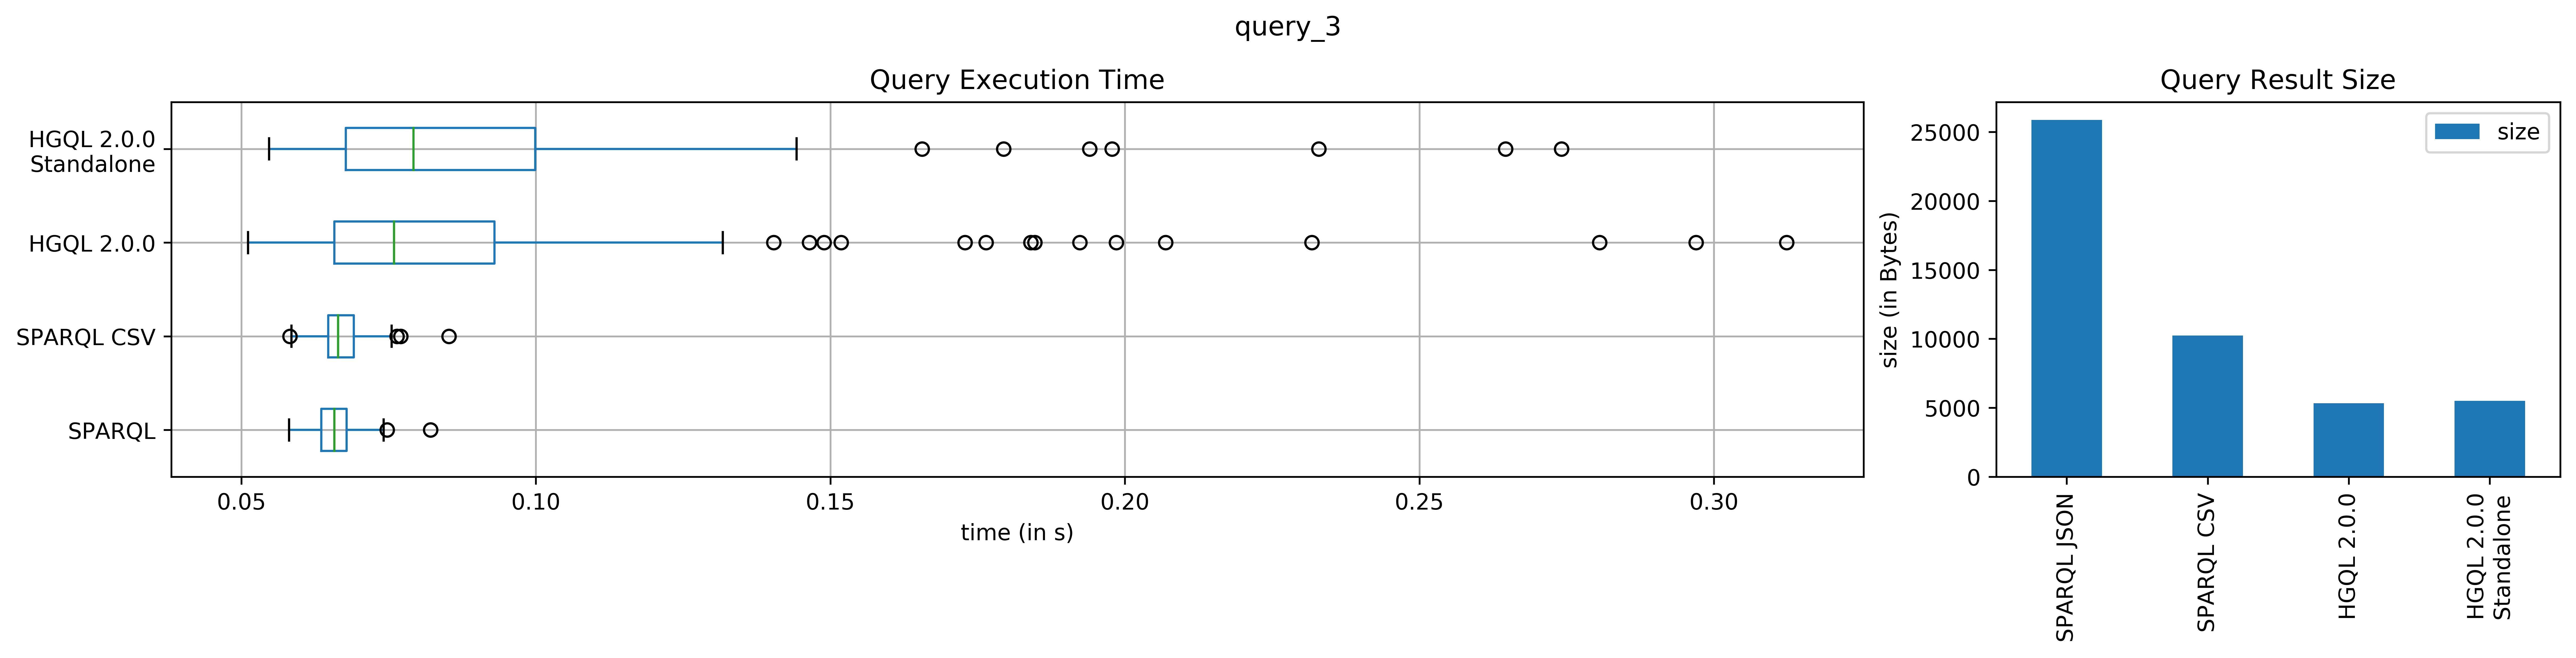

In [20]:
for i, hgql_query in enumerate(hgql2_queries):   
    tim = all_timings[i]
    size = sizes[i]
    label = ['SPARQL JSON', 'SPARQL CSV','HGQL 2.0.0','HGQL 2.0.0\nStandalone']
    y_pos = np.arange(len(label))
    df2 = pd.DataFrame({"method":label,'size': [size['sparql'],size['sparql_csv'],size['hgql2'],size['hgql2s']]})
    a = np.array([np.hstack(tim['sparql']),np.hstack(tim['sparql_csv']), np.hstack(tim['hgql2']), np.hstack(tim['hgql2s'])]).transpose()
    df = pd.DataFrame(a, columns=['SPARQL','SPARQL CSV', 'HGQL 2.0.0', 'HGQL 2.0.0\nStandalone'])
    
    fig3 = plt.figure(constrained_layout=True,figsize=(16, 4),dpi=600)   
    gs = fig3.add_gridspec(1, 20)
    f3_ax1 = fig3.add_subplot(gs[0, :15])
    df.boxplot(ax=f3_ax1,vert=False, figsize=(16, 4))
    f3_ax1.set_title('Query Execution Time')
    f3_ax1.set_xlabel('time (in s)')
    f3_ax2 = fig3.add_subplot(gs[0, 15:])
    df2[['method','size']].plot(ax=f3_ax2, kind='bar')
    f3_ax2.set_title('Query Result Size')
    
    f3_ax2.set_xticklabels(label, minor=False)
    f3_ax2.set_ylabel('size (in Bytes)')
    fig3.suptitle(tim['name'])
    fig3.savefig("%s/%s.pdf" % (OUTPUT_FOLDER_MULTIPLE_SERVICES, tim['name']), bbox_inches='tight')


In [21]:
pd.DataFrame.from_dict(test_results)

name  time_sparql  result_sparql  time_hgql_2_standalone  \
0  query_1     0.011770            255                0.026463   
1  query_2     9.116257        1015149                0.660488   
2  query_3     0.066062          25867                0.092960   

   result_hgql_2_standalone  time_hgql_2  result_hgql_2 time_diff_to_sparql  \
0                       230     0.039771            230               0.028   
1                    188826     1.006859         188742                -8.1   
2                      5516     0.095003           5327               0.029   

  time_diff_percent_to_sparql time_diff_percent_to_sparql_transformer  \
0                         30%                                1.3e+02%   
1                    9.1e+02%                                1.3e+02%   
2                         70%                                1.3e+02%   

  time_diff_to_sparql_csv time_diff_to_hgql_standalone  
0                  0.028%                       0.013%  
1                   -7.9%                        0.35%  
2                  0.028%                       0.002%

## Dbpedia Query Tests

Start HyperGraphQL server - wait 20sec for servert booting

In [22]:
INPUT_FOLDER_DBPEDIA = INPUT_FOLDER + '/dbpedia'
OUTPUT_FOLDER_DBPEDIA = INPUT_FOLDER_DBPEDIA + '/results'

HGQL_ENDPOINT = 'http://localhost:8098/graphql'
SPARQL_ENDPOINT = 'https://dbpedia.org/sparql'

hgql_queries_files = list(filter(lambda x: x.endswith('.graphql'), os.listdir(INPUT_FOLDER_DBPEDIA)))
hgql_queries_files.sort()
print(hgql_queries_files)
rq_queries_files = list(filter(lambda x: x.endswith('.sparql'), os.listdir(INPUT_FOLDER_DBPEDIA)))
rq_queries_files.sort()
print(rq_queries_files)
json_queries_files = list(filter(lambda x: x.endswith('.json'), os.listdir(INPUT_FOLDER_DBPEDIA)))
json_queries_files.sort()
print(json_queries_files)

hgql_queries = [open('%s/%s' % (INPUT_FOLDER_DBPEDIA, f), 'r').read() for f in hgql_queries_files]
rq_queries = [open('%s/%s' % (INPUT_FOLDER_DBPEDIA, f), 'r').read() for f in rq_queries_files]
json_queries = [json.load(open('%s/%s' % (INPUT_FOLDER_DBPEDIA, f), 'r')) for f in json_queries_files]

['query_1_hgql_2.0.0.graphql', 'query_2_hgql_2.0.0.graphql']
['query_1.sparql', 'query_2.sparql']
['query_1.json', 'query_2.json']


In [23]:
test_results = []
all_timings = []
sizes = []

for i, hgql_query in enumerate(hgql_queries):
    # queries
    hgql_query = hgql_queries[i]
    rq_query = rq_queries[i]
    json_query = json_queries[i]
    title = rq_queries_files[i].replace('.sparql', '')
    print(title)

    # progress bars
    fs = FloatProgress(min=0, max=num_iteration, description='SPARQL test:')
    display(fs)
    fj = FloatProgress(min=0, max=num_iteration, description='HGQL test:')
    display(fj)

    sparql_time = []
    sparql_results = 0
    sparql_csv_time = []
    sparql_csv_results = 0
    hgql_time = []
    hgql_results = 0
    json_time = []
    json_results = 0
    print("SPARQL JSON")
    save_res_exec_query(title, rq_query,SPARQL_ENDPOINT, folder=OUTPUT_FOLDER_DBPEDIA, typ='sparql_dbpedia')
    for j in np.arange(num_iteration):
        if (i + j) > 0:
                time.sleep(sleep_time)
        size, t = test_atom(rq_query,SPARQL_ENDPOINT, typ='sparql_dbpedia')
        sparql_time.append(t)
        sparql_results = size
        fs.value += 1
    print("SPARQL CSV")
    save_res_exec_query(title, rq_query,SPARQL_ENDPOINT, folder=OUTPUT_FOLDER_DBPEDIA, typ='sparql_csv')
    for j in np.arange(num_iteration):
        if (i + j) > 0:
                time.sleep(sleep_time)
        size, t = test_atom(rq_query,SPARQL_ENDPOINT, typ='sparql_csv')
        sparql_csv_time.append(t)
        sparql_csv_results = size
        fs.value += 1
    print("HGQL")
    save_res_exec_query(title, hgql_query,HGQL_ENDPOINT, folder=OUTPUT_FOLDER_DBPEDIA, typ='hgql')
    for j in np.arange(num_iteration):
        time.sleep(sleep_time)
        size, t = test_atom(hgql_query, HGQL_ENDPOINT, typ='hgql')
        hgql_time.append(t)
        hgql_results = size
        fj.value += 1
    print("SPARQLTransformer")
    save_res_exec_query(title, json_query,SPARQL_ENDPOINT, folder=OUTPUT_FOLDER_DBPEDIA, typ='json')
    for j in np.arange(num_iteration):
        time.sleep(sleep_time)
        size, t = test_atom(json_query,SPARQL_ENDPOINT, typ='json')
        json_time.append(t)
        json_results = size
        fj.value += 1

    ts = np.mean(sparql_time)
    th = np.mean(hgql_time)
    tj = np.mean(json_time)
    time_diff_to_sparql = (th - ts)
    time_diff_to_sparql_transformer = (th - tj)
    time_diff_percent_to_sparql = 100 * time_diff_to_sparql / np.mean([ts, th])
    time_diff_percent_to_sparql_transformer = 100 * time_diff_to_sparql_transformer / np.mean([tj, th])

    test_results.append({
      'name': title,
      'time_sparql': ts,
      'result_sparql': sparql_results,
      'time_json': tj,
      'result_json': json_results,
      'time_hgql': th,
      'result_hgql': hgql_results,
      'time_diff_to_sparql': '{0:.2g}'.format(time_diff_to_sparql),
      'time_diff_percent_to_sparql': '{0:.2g}%'.format(time_diff_percent_to_sparql),
      'time_diff_to_sparql_transformer': '{0:.2g}'.format(time_diff_to_sparql_transformer),
      'time_diff_percent_to_sparql_transformer': '{0:.2g}%'.format(time_diff_percent_to_sparql_transformer)
    });

    all_timings.append({
      'name': title,
      'hgql': hgql_time,
      'sparql': sparql_time,
      'sparql_csv':sparql_csv_time,
      'json': json_time
    })
    sizes.append({
      'name': title,
      'sparql': sparql_results,
      'sparql_csv': sparql_csv_results,
      'json': json_results,
      'hgql': hgql_results
    })

query_1


FloatProgress(value=0.0, description='SPARQL test:')

FloatProgress(value=0.0, description='HGQL test:')

SPARQL JSON
SPARQL CSV
HGQL
SPARQLTransformer
query_2


FloatProgress(value=0.0, description='SPARQL test:')

FloatProgress(value=0.0, description='HGQL test:')

SPARQL JSON
SPARQL CSV
HGQL
SPARQLTransformer


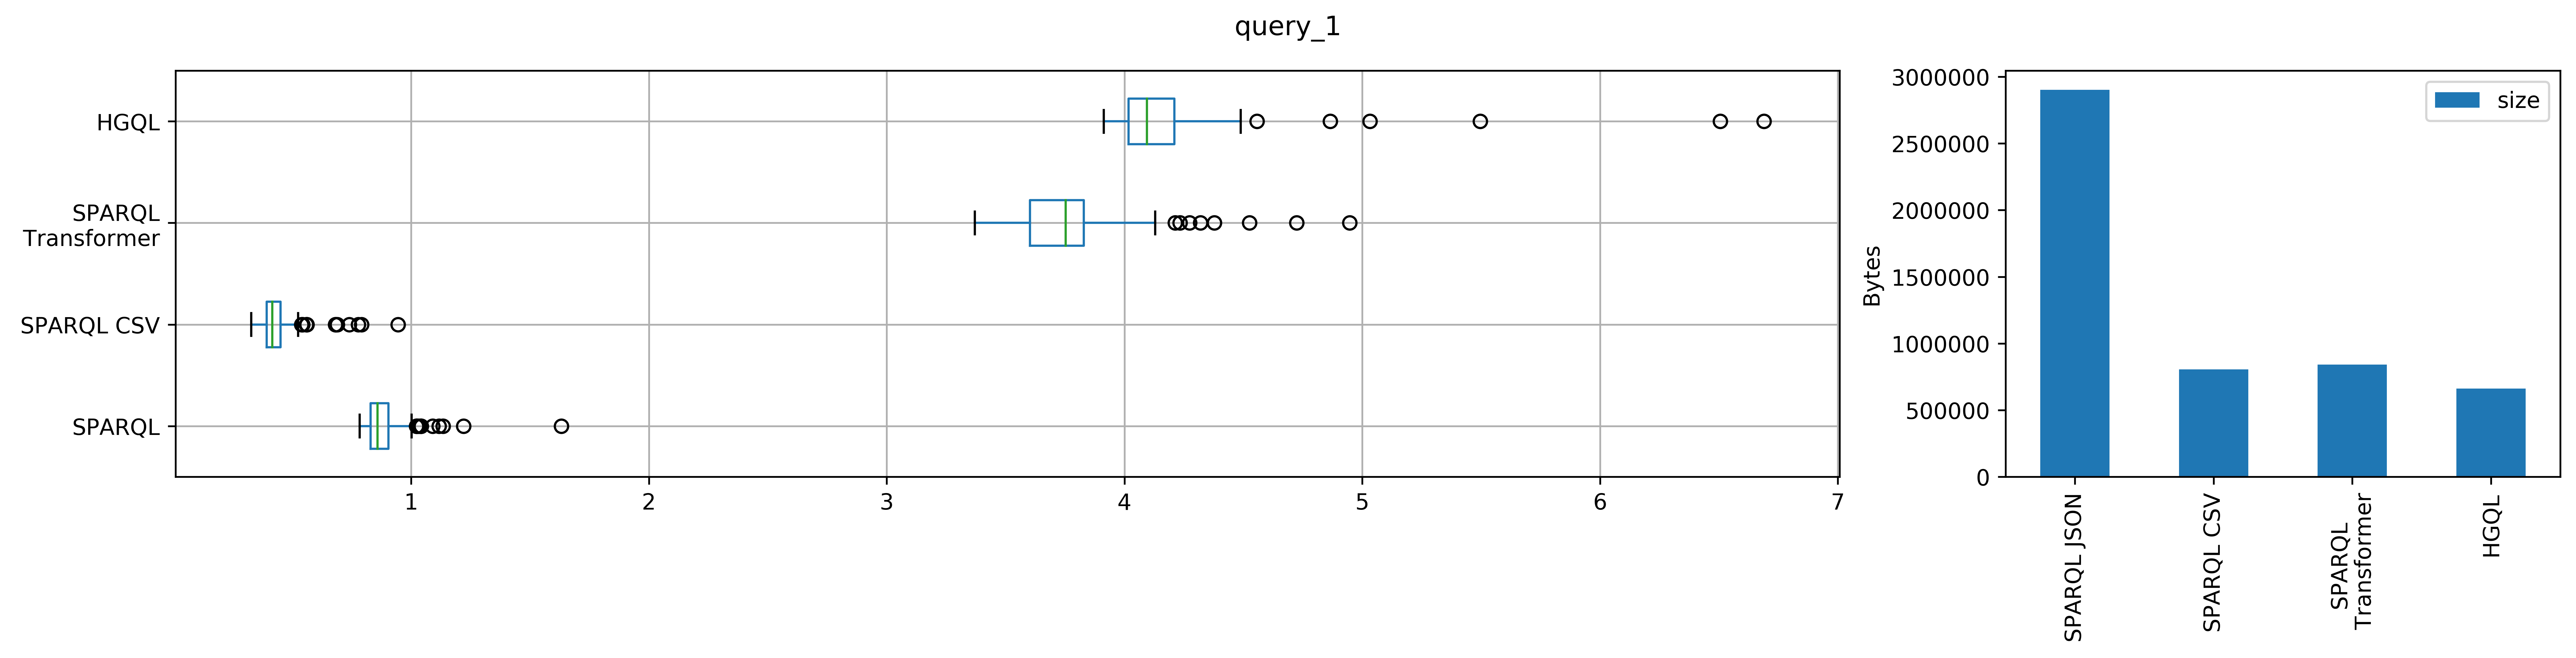

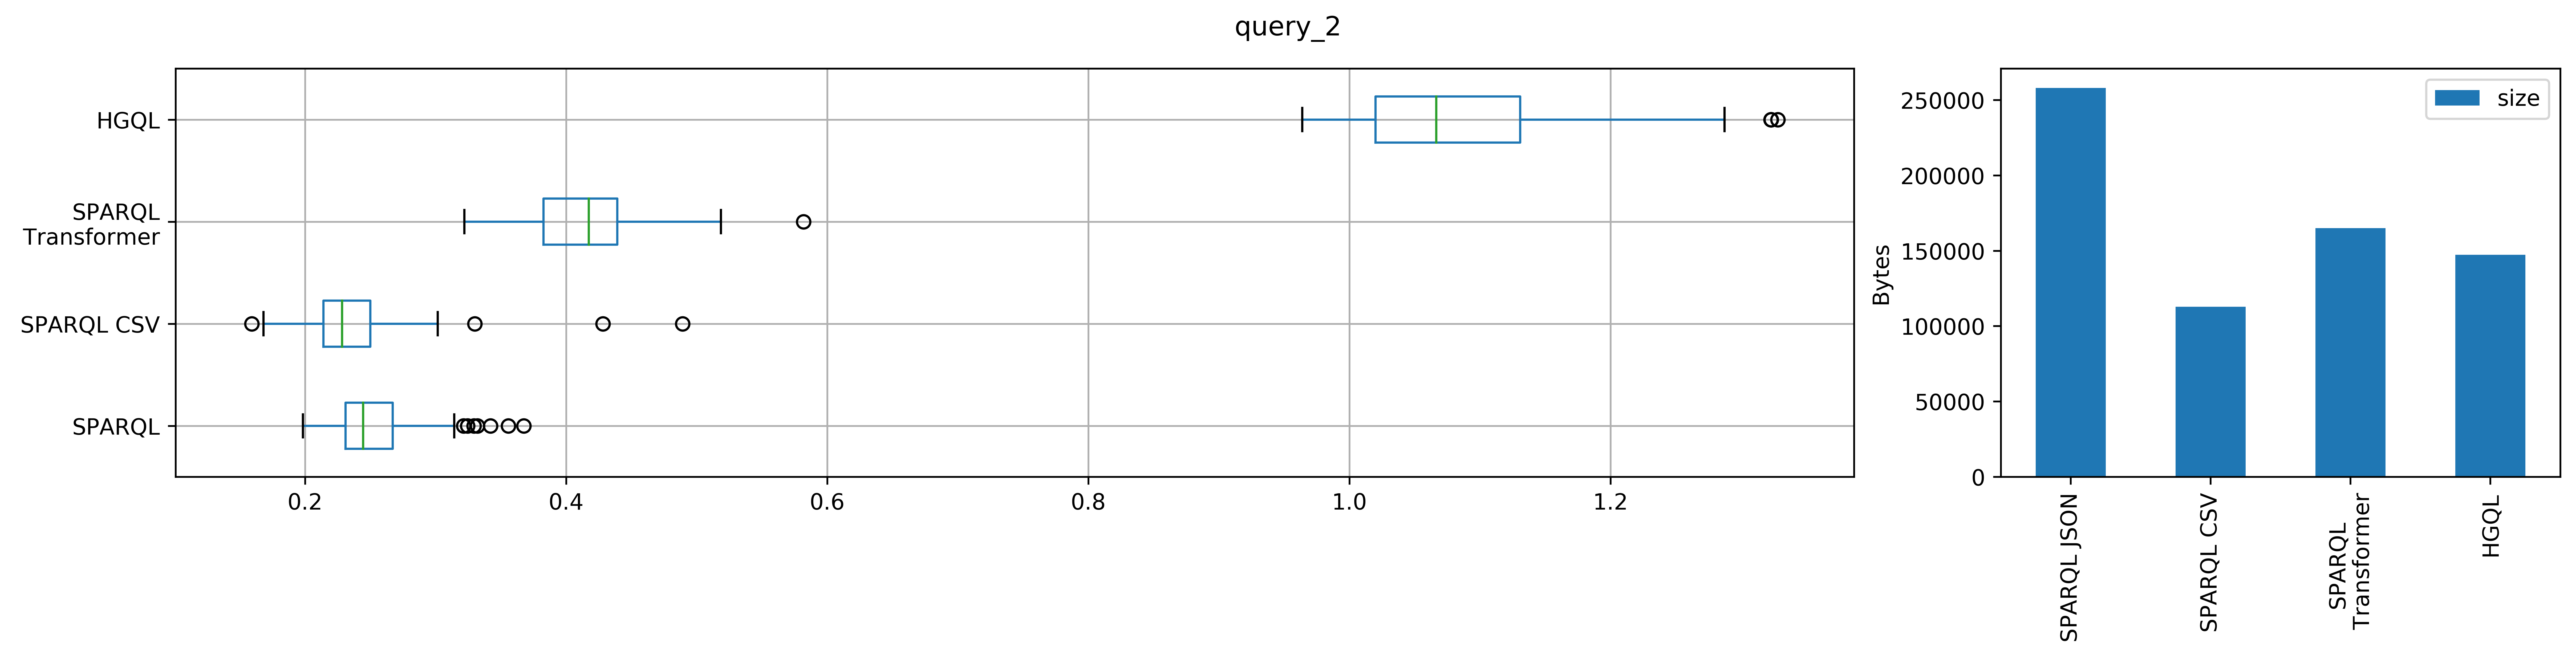

In [24]:
for i, hgql_query in enumerate(hgql_queries):   
    tim = all_timings[i]
    size = sizes[i]
    label = ['SPARQL JSON', 'SPARQL CSV', 'SPARQL\n Transformer', 'HGQL']
    y_pos = np.arange(len(label))
    df2 = pd.DataFrame({"method":label,'size': [size['sparql'],size['sparql_csv'],size['json'],size['hgql']]})
    a = np.array([np.hstack(tim['sparql']),np.hstack(tim['sparql_csv']),np.hstack(tim['json']), np.hstack(tim['hgql'])]).transpose()
    df = pd.DataFrame(a, columns=['SPARQL','SPARQL CSV', 'SPARQL\n Transformer', 'HGQL'])
    
    fig3 = plt.figure(constrained_layout=True,figsize=(16, 4),dpi=600)   
    gs = fig3.add_gridspec(1, 20)
    f3_ax1 = fig3.add_subplot(gs[0, :15])
    df.boxplot(ax=f3_ax1,vert=False, figsize=(16, 4))
    f3_ax1.set_title('')
    f3_ax2 = fig3.add_subplot(gs[0, 15:])
    df2[['method','size']].plot(ax=f3_ax2, kind='bar')
    f3_ax2.set_title('')
    f3_ax2.set_xticklabels(label, minor=False)
    f3_ax2.set_ylabel('Bytes')
    fig3.suptitle(tim['name'])
    fig3.savefig("%s/%s.pdf" % (OUTPUT_FOLDER_DBPEDIA, tim['name']), bbox_inches='tight')


In [25]:
pd.DataFrame.from_dict(test_results)

name  time_sparql  result_sparql  time_json  result_json  time_hgql  \
0  query_1     0.886874        2901226   3.771636       842178   4.193481   
1  query_2     0.252515         257930   0.414881       165020   1.083891   

   result_hgql time_diff_to_sparql time_diff_percent_to_sparql  \
0       661452                 3.3                    1.3e+02%   
1       147296                0.83                    1.2e+02%   

  time_diff_to_sparql_transformer time_diff_percent_to_sparql_transformer  
0                            0.42                                     11%  
1                            0.67                                     89%

In [ ]:
all_timings

## Mutation

In [15]:
INPUT_FOLDER_MUTATION = INPUT_FOLDER + '/mutations'
OUTPUT_FOLDER_MUTATION = INPUT_FOLDER_MUTATION + '/results'

HGQL_ENDPOINT = 'http://localhost:8098/graphql'
SPARQL_MUTATION_ENDPOINT = "http://localhost:3030/mutation2/update"
SPARQL_QUERY_ENDPOINT = 'http://localhost:3030/mutation/query'

hgql_mutation_files = list(filter(lambda x: x.endswith('.graphql'), os.listdir(INPUT_FOLDER_MUTATION)))
hgql_mutation_files.sort()
print(hgql_mutation_files)
rq_mutation_files = list(filter(lambda x: x.startswith('mutation') and x.endswith('.sparql'), os.listdir(INPUT_FOLDER_MUTATION)))
rq_mutation_files.sort()
print(rq_mutation_files)
rq_query_files = list(filter(lambda x: x.startswith('query') and x.endswith('.sparql'), os.listdir(INPUT_FOLDER_MUTATION)))
rq_query_files.sort()
print(rq_query_files)


hgql_mutations = [open('%s/%s' % (INPUT_FOLDER_MUTATION, f), 'r').read() for f in hgql_mutation_files]
rq_mutations = [open('%s/%s' % (INPUT_FOLDER_MUTATION, f), 'r').read() for f in rq_mutation_files]
rq_queries = [open('%s/%s' % (INPUT_FOLDER_MUTATION, f), 'r').read() for f in rq_query_files]

['mutation_1.graphql', 'mutation_2.graphql']
['mutation_1.sparql', 'mutation_2.sparql']
['query_1.sparql', 'query_2.sparql']


In [16]:
test_results = []
all_timings = []
sizes = []

for i, hgql_mutation in enumerate(hgql_mutations):
    # queries
    if(i==0):
        wait_for_server("Start HGQL server for the mutations Test: Confirm with y")
    if(i==1):
        wait_for_server("Check if the insertions where executed correctly: Confirm with y")
    hgql_mutation = hgql_mutations[i]
    rq_mutation = rq_mutations[i]
    rq_query = rq_queries[i]
    title = rq_mutation_files[i].replace('.sparql', '')
    print(title)

    # progress bars
    fs = FloatProgress(min=0, max=num_iteration, description='SPARQL test:')
    display(fs)
    fj = FloatProgress(min=0, max=num_iteration, description='HGQL test:')
    display(fj)

    sparql_time = []
    sparql_results = 0
    hgql_time = []
    hgql_results = 0
    print("SPARQL JSON")
    for j in np.arange(num_iteration):
        if (i + j) > 0:
                time.sleep(sleep_time)
        mutation = rq_mutation.replace('%s', str(j)+ 'sparql')
        sparql_results_mutation, t_mutation = test_atom(mutation,SPARQL_MUTATION_ENDPOINT, typ='sparql_mutation')
        sparql_results_query, t_query = test_atom(rq_query,SPARQL_QUERY_ENDPOINT, typ='sparql')
        sparql_time.append(t_mutation + t_query)
        fs.value += 1

    print("HGQL")
    for j in np.arange(num_iteration):
        time.sleep(sleep_time)
        mutation = hgql_mutation.replace('%s', str(j) + 'hgql')
        hgql_results, t = test_atom(mutation, HGQL_ENDPOINT, typ='hgql')
        hgql_time.append(t)
        fj.value += 1
    
    ts = np.mean(sparql_time)
    th = np.mean(hgql_time)
    time_diff_to_sparql = (th - ts)
    time_diff_percent_to_sparql = 100 * (ts / th)

    test_results.append({
      'name': title,
      'time_sparql': ts,
      'result_sparql': sparql_results,
      'time_hgql': th,
      'result_hgql': hgql_results,
      'time_diff_to_sparql': '{0:.2g}'.format(time_diff_to_sparql),
      'time_diff_percent_to_sparql': '{0:.2g}%'.format(time_diff_percent_to_sparql),
    });

    all_timings.append({
      'name': title,
      'hgql': hgql_time,
      'sparql': sparql_time,
    })
    sizes.append({
      'name': title,
      'sparql': len(rq_mutation) + len(rq_query),
      'hgql': len(hgql_mutation)
    })

Close current HGQL instannce and start Start HGQL server for the mutations Test: Confirm with y. Done? Confirm with y if the server is accessible y


mutation_1


FloatProgress(value=0.0, description='SPARQL test:')

FloatProgress(value=0.0, description='HGQL test:')

SPARQL JSON
HGQL


Close current HGQL instannce and start Check if the insertions where executed correctly: Confirm with y. Done? Confirm with y if the server is accessible y


mutation_2


FloatProgress(value=0.0, description='SPARQL test:')

FloatProgress(value=0.0, description='HGQL test:')

SPARQL JSON
HGQL


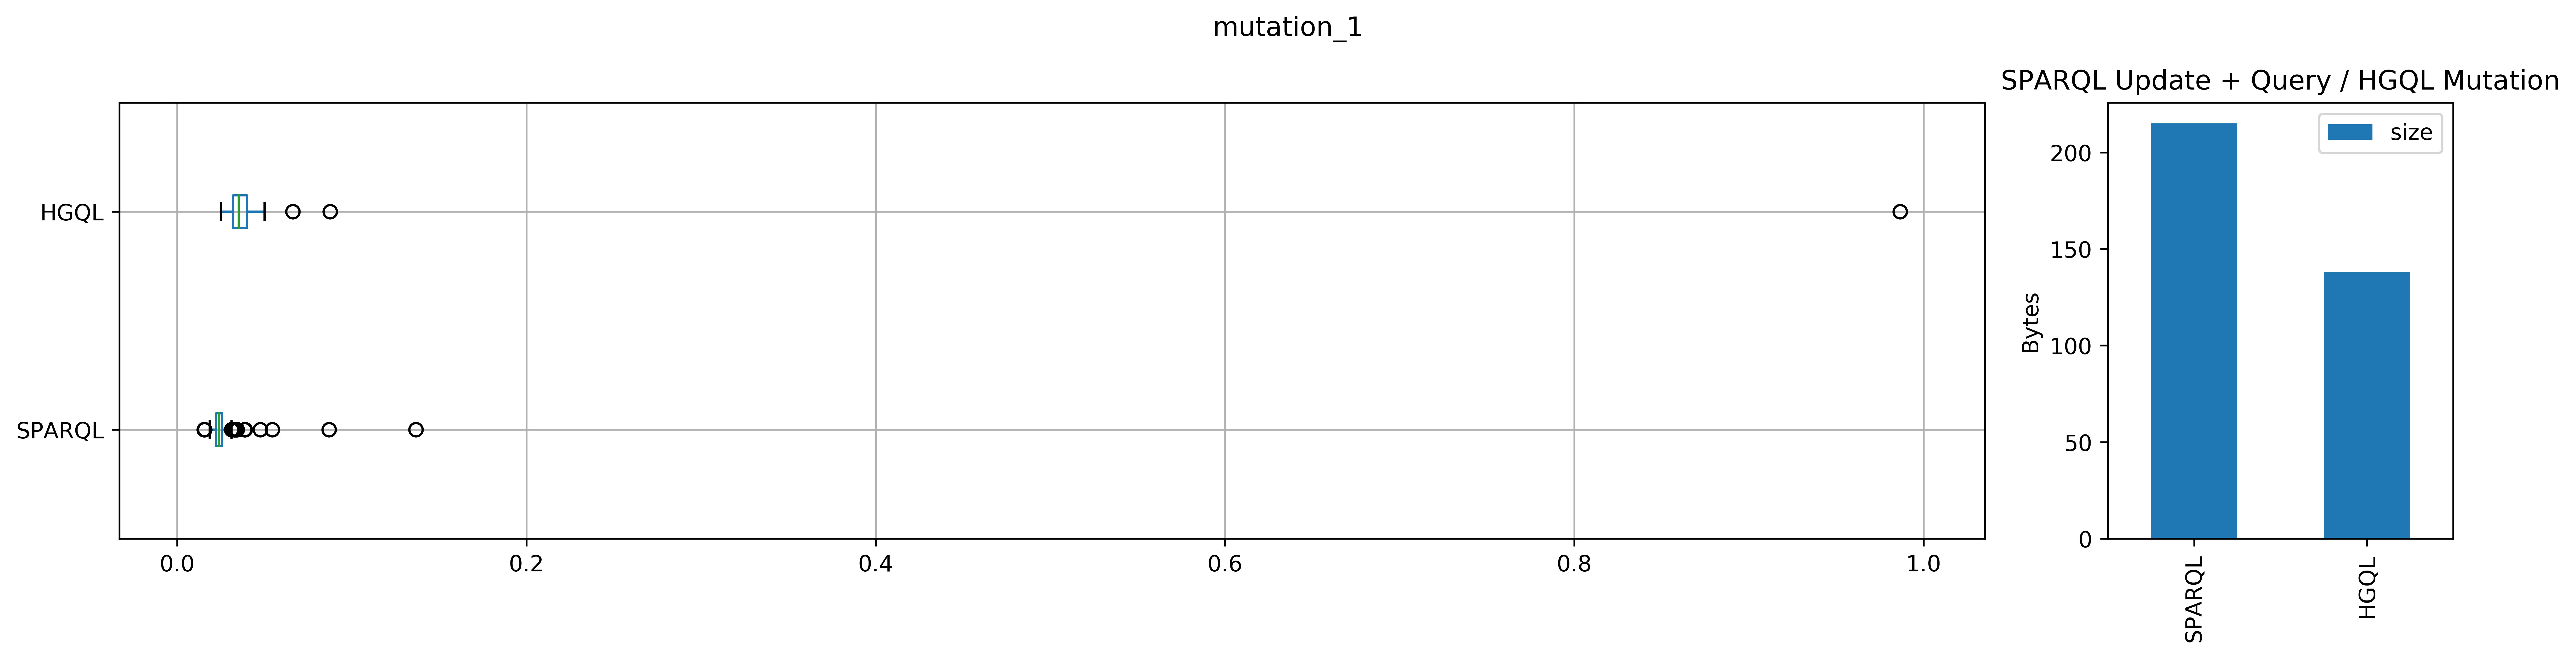

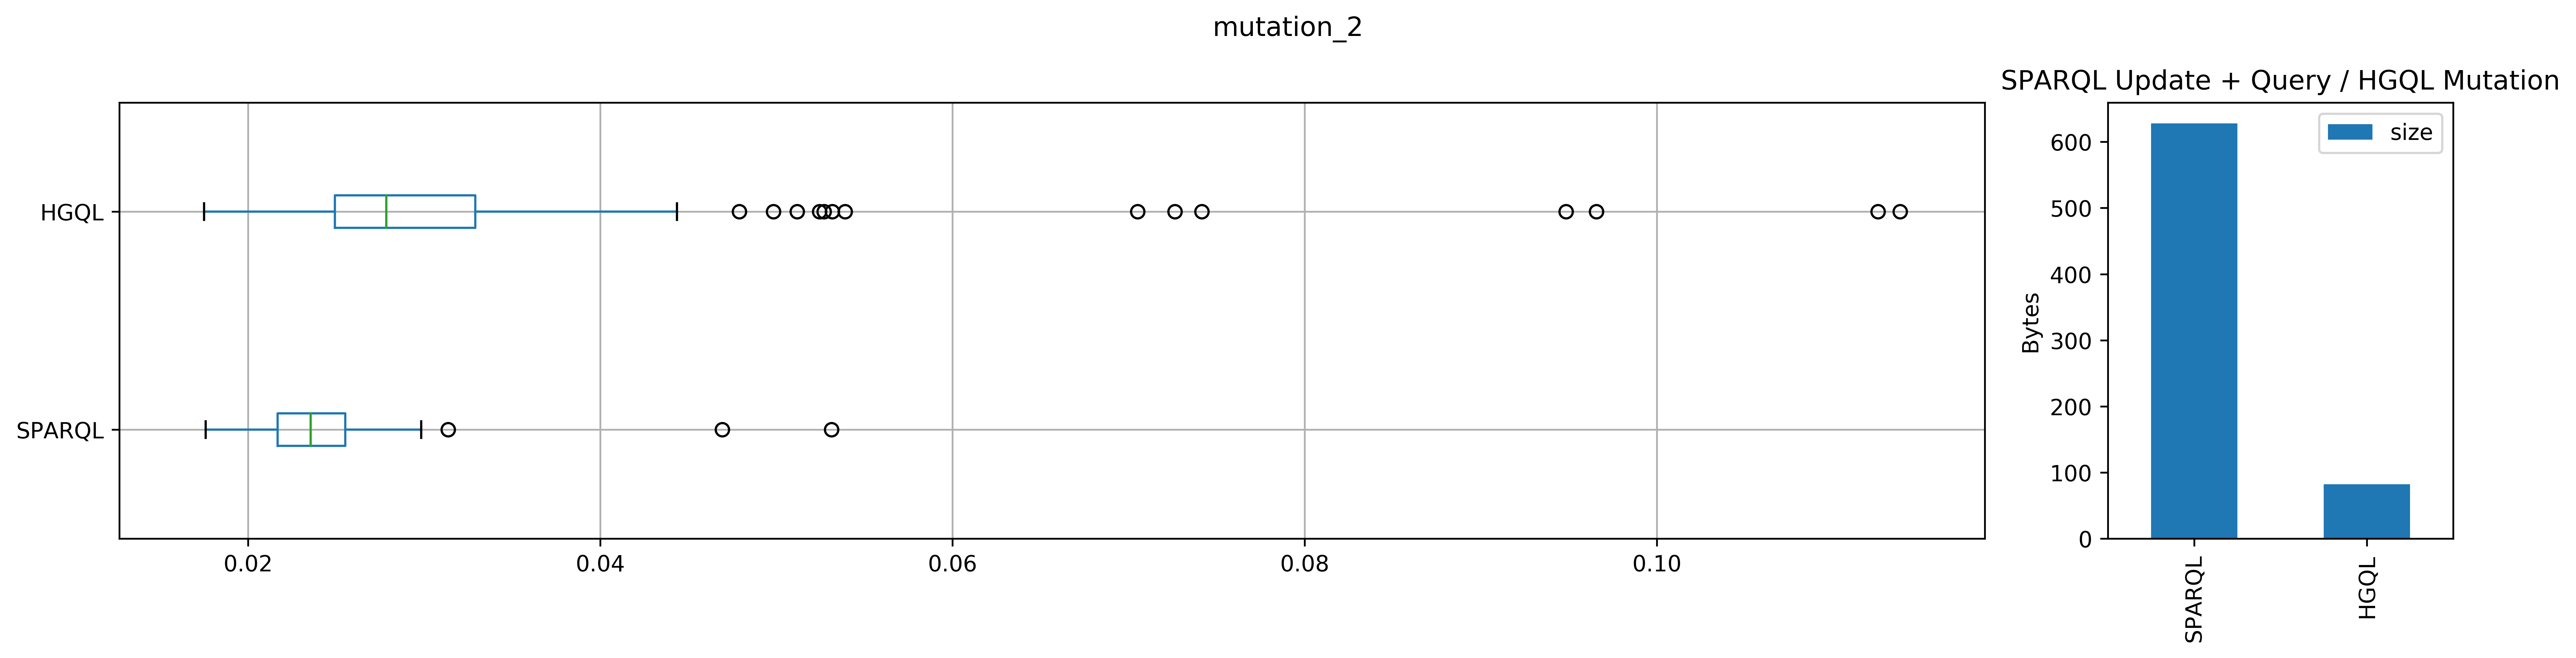

In [18]:
for i, hgql_query in enumerate(hgql_mutations):   
    tim = all_timings[i]
    size = sizes[i]
    label = ['SPARQL', 'HGQL']
    y_pos = np.arange(len(label))
    df2 = pd.DataFrame({"method":label,'size': [size['sparql'],size['hgql']]})
    a = np.array([np.hstack(tim['sparql']), np.hstack(tim['hgql'])]).transpose()
    df = pd.DataFrame(a, columns=['SPARQL', 'HGQL'])
    
    fig3 = plt.figure(constrained_layout=True,figsize=(16, 4),dpi=600)   
    gs = fig3.add_gridspec(1, 20)
    f3_ax1 = fig3.add_subplot(gs[0, :15])
    df.boxplot(ax=f3_ax1,vert=False, figsize=(16, 4))
    f3_ax1.set_title('')
    f3_ax2 = fig3.add_subplot(gs[0, 15:])
    df2[['method','size']].plot(ax=f3_ax2, kind='bar')
    f3_ax2.set_title('SPARQL Update + Query / HGQL Mutation')
    f3_ax2.set_xticklabels(label, minor=False)
    f3_ax2.set_ylabel('Bytes')
    fig3.suptitle(tim['name'])
    fig3.savefig("%s/%s.pdf" % (OUTPUT_FOLDER_MUTATION, tim['name']), bbox_inches='tight')


In [30]:
pd.DataFrame.from_dict(test_results)

name  time_sparql  result_sparql  time_hgql  result_hgql  \
0  mutation_1     0.018267              0   0.056559         8864   
1  mutation_2     0.018829              0   0.020566         1207   

  time_diff_to_sparql time_diff_percent_to_sparql  
0               0.038                         32%  
1              0.0017                         92%